<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from pymystem3 import Mystem
import re
import nltk 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer  
import re  
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [2]:
#импортируем данные
df = pd.read_csv('/datasets/toxic_comments.csv')
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
df.duplicated().value_counts()

False    159571
dtype: int64

In [5]:
#посмотрим на значения столбца toxic
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

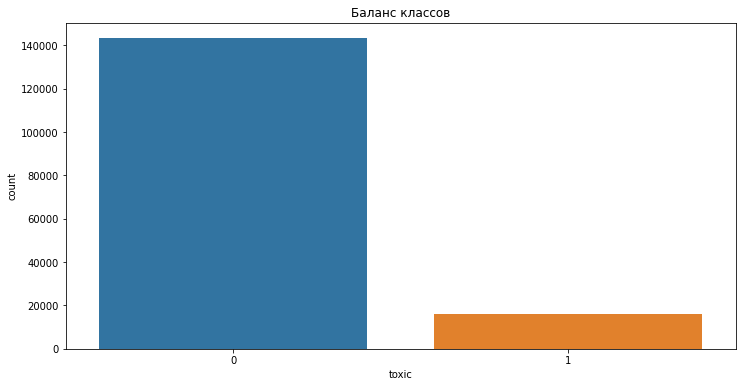

In [6]:
plt.figure(figsize=(12, 6))
sns.countplot(x='toxic', data=df)
plt.title('Баланс классов')
plt.show()

**Вывод:** Наблюдается явный дисбаланс положительного и отрицательного классов.

In [7]:
#приведем значения столбца text к нижнему регистру
df['text'] = df['text'].str.lower()

Проведём лемматизацию, с помошью WordNetLemmatizer и напишем функции для очистки текстов.

In [8]:
#Проведём лемматизацию, с помошью WordNetLemmatizer
wnl = WordNetLemmatizer()

def clear_text(text):
    pattern = re.sub(r'[^a-zA-Z]', ' ', text)
    clear = pattern.split()
    lemm = []
    for i in range(len(clear)):
        lemm.append(wnl.lemmatize(clear[i]))
    return " ".join(lemm)

df['lemmatize'] = df['text'].apply(clear_text)

In [9]:
df.head()

,text,toxic,lemmatize
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...


**Общий вывод:** Данные загружены и проверены, пропусков и дубликатов нет. Есть дисбаланс классов, нужно это учитывать при обучение моделей. Проведена лемматизация данных. 

## Обучение

Определяем признаки и целевой признак. 

In [10]:
features = df.drop(['toxic'], axis = 1)
target = df['toxic']

Разделим датасет на тренировочную и тестовую выборки:

In [11]:
features_train, features_test, target_train, target_test= train_test_split(features, target, test_size=0.3, random_state=12345)
print(features_train.shape)
print(features_test.shape)

(111699, 2)
(47872, 2)


Определим стоп-слова и проведём векторизацию текста:

In [12]:
corpus_train = features_train['lemmatize'].values.astype('U')
corpus_test = features_test['lemmatize'].values.astype('U')

stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)
print(tf_idf_train.shape)
print(tf_idf_test.shape)

(111699, 128561)
(47872, 128561)


Обучим модель Логической регресии:

In [13]:
model = LogisticRegression(random_state=12345, solver = 'liblinear', class_weight='balanced')
model.fit(tf_idf_train, target_train)
predicted_test_LR = model.predict(tf_idf_test)
f1_LR = f1_score(target_test, predicted_test_LR)
print("F1 модели Логическая регрессия:", f1_LR)

F1 модели Логическая регрессия: 0.7513732552904098


Обучим модель Случайный лес:

In [14]:
model = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=12345, class_weight='balanced')
model.fit(tf_idf_train, target_train)
predicted_test_forest = model.predict(tf_idf_test)
f1_RFC = f1_score(target_test, predicted_test_forest)
print("F1 модели Случайный лес:", f1_RFC)

F1 модели Случайный лес: 0.35861951136169484


Обучим модель Дерево решений:

In [15]:
model = DecisionTreeClassifier(max_depth=9, random_state=12345, class_weight='balanced')
model.fit(tf_idf_train, target_train)
predicted_test_tree = model.predict(tf_idf_test)
f1_DTC = f1_score(target_test, predicted_test_tree)
print("F1 модели Дерево решений:", f1_DTC)

F1 модели Дерево решений: 0.5584361569388603


Для обучения модели LGBMClassifier придётся существенно сократить данные, на которых обучается модель. Иначе постоянно умирает ядро юпитера.

In [16]:
count_tf_idf_LGBMC = TfidfVectorizer(stop_words=stopwords, min_df = 100)

tf_idf_train_LGBMC = count_tf_idf_LGBMC.fit_transform(corpus_train)
#tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test_LGBMC = count_tf_idf_LGBMC.transform(corpus_test)
print(tf_idf_train_LGBMC.shape)
print(tf_idf_test_LGBMC.shape)

(111699, 3649)
(47872, 3649)


In [17]:
model = LGBMClassifier(random_state=12345, class_weight='balanced')
model.fit(tf_idf_train_LGBMC, target_train)
predicted_test_LGBMC = model.predict(tf_idf_test_LGBMC)
f1_LGBMC = f1_score(target_test, predicted_test_LGBMC)
print("F1 модели LGBMClassifier:", f1_LGBMC)

LGBMClassifier: 0.7061265000451141


Проверим адекватность с помощью константной модели:

In [18]:
#Проверим адекватность моделей
target_pred_constant = [1 for i in range(len(target_test))]
print("F1 константной модели:" , f1_score(target_test, target_pred_constant))

F1: 0.18491345807503462


Тест на адекватность пройден. Все модели справляются лучше константной.

## Выводы

Объединим результаты всех моделей в общую таблицу.

In [19]:
results = {
    'Model' : ['LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier', 'LGBMClassifier'],
    'F1' :pd.Series([f1_LR, f1_RFC, f1_DTC ,f1_LGBMC]),
    }
display(pd.DataFrame(results))

,Model,F1
0,LogisticRegression,0.751373
1,RandomForestClassifier,0.358620
2,DecisionTreeClassifier,0.558436
3,LGBMClassifier,0.706127


**Вывод:** Лучшие результаты показывает модель Логической регрессии. Она же, единственная, уложилось в необходимое значение f1 > 0.75. 
По видимому, Логистическая регрессия является оптимальным решением для данного типа задач. т.к. работает быстрее и качественее других моделей.